In [ ]:
#importing libraries and dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

In [11]:
#finding shape of the dataset
data.shape

(4998, 141)

In [12]:
#splitting training and testing dataset
features = data.drop(140, axis=1)
target = data[140]
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [13]:
#scaling the data using MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [14]:
#creating autoencoder subclass by extending Model class from keras
class AutoEncoder(Model):
  def __init__(self, output_units, ldim=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(ldim, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
#model configuration
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
epochs = 20

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0115 - mse: 0.0261 - val_loss: 0.0133 - val_mse: 0.0308
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - mse: 0.0243 - val_loss: 0.0128 - val_mse: 0.0298
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0096 - mse: 0.0217 - val_loss: 0.0127 - val_mse: 0.0292
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083 - mse: 0.0187 - val_loss: 0.0119 - val_mse: 0.0275
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - mse: 0.0163 - val_loss: 0.0116 - val_mse: 0.0266
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - mse: 0.0139 - val_loss: 0.0109 - val_mse: 0.0252
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - mse: 0.0122 - val_loss: 0.0105 - val_mse: 0.0242
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049 - mse: 0.0109 - val_loss: 0.0099 - val_mse: 0.0229
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - mse: 0.0100 -

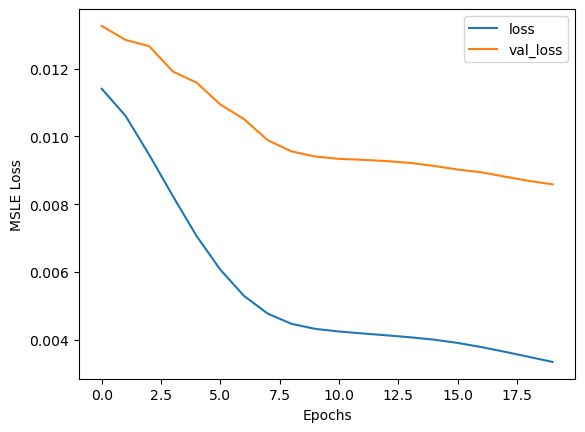

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()


In [17]:
#finding threshold for anomaly and doing predictions
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  threshold = np.mean(reconstruction_errors.numpy()) \
   + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Threshold: 0.007854251627739903


In [18]:
#getting accuracy score
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.96